In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [34]:
df = pd.read_csv('../data/processed/AAPL.US.csv')
df.index = df["date"]
df.drop("date", axis=1, inplace=True)
df

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2010-01-04,213.4300,6.4246,493729600,NaN,0,1,1,2010,4,4,1,NaN,NaN,6.424600,0.000000,NaN,2.1196,NaN,6.4357
2010-01-05,214.6004,6.4357,601904800,0.0111,1,1,1,2010,5,5,1,6.4246,NaN,6.430767,0.000125,NaN,2.3380,NaN,6.3333
2010-01-06,214.3792,6.3333,552160000,-0.1024,2,1,1,2010,6,6,1,6.4357,NaN,6.390821,-0.001399,NaN,4.4800,NaN,6.3216
2010-01-07,211.7500,6.3216,477131200,-0.0117,3,1,1,2010,7,7,1,6.3333,NaN,6.367372,-0.002316,NaN,2.9484,NaN,6.3637
2010-01-08,210.2996,6.3637,447610800,0.0421,4,1,1,2010,8,8,1,6.3216,NaN,6.366280,-0.002022,NaN,2.9400,NaN,6.3075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,226.2700,224.9000,30621200,-1.1100,3,3,8,2025,233,21,34,226.0100,225.496838,226.752776,5.719125,1.393873,2.7400,11.287607,227.7600
2025-08-22,226.1700,227.7600,42477800,2.8600,4,3,8,2025,234,22,34,224.9000,227.425300,226.954220,5.804223,1.610536,3.6800,11.517056,227.1600
2025-08-25,226.4800,227.1600,30983100,-0.6000,0,3,8,2025,237,25,35,227.7600,228.513892,226.995376,5.836679,1.535379,3.0700,11.524136,229.3100


##### Extraemos el ultimo valor
Es para simular la prediccion de mañana

In [35]:
last_row = df.tail(1)
df.drop(df.tail(1).index, inplace=True)
df.dropna(inplace=True)

In [36]:
last_row

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-27,228.58,230.49,30134069,1.18,2,3,8,2025,239,27,35,229.31,229.354615,228.064641,6.060884,1.821901,2.605,10.309129,NaN


In [37]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [38]:
def train_test_split(df, test_size=0.2):
    data = df.values
    
    feature_scaler.fit(data[:, :-1]) 
    target_scaler.fit(data[:, -1:]) 
    scaled_data = feature_scaler.transform(data[:, :-1])
    scaled_target = target_scaler.transform(data[:, -1:])
    data_scaled = np.concatenate((scaled_data, scaled_target), axis=1)
    
    
    n = int(len(data_scaled) * (1 - test_size))
    return data_scaled[:n], data_scaled[n:]

In [39]:
def xgb_prediction(train, value):
    train = np.array(train)
    X, Y = train[:, :-1], train[:, -1]
    global model                                                                 # global model hace que pille la variable model fuera de la funcion, siendo asi una variable global y no una local
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

    model.fit(X, Y)
    val = np.array(value).reshape(1, -1)
    prediction = model.predict(val)
    return prediction[0] 

In [40]:
def walk_forward_validation(data, percentage=0.2):
    # In this case -1 is the target column (last one)
    train, test = train_test_split(data, percentage)
    predictions = []
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_Y = test[i, :-1], test[i, -1] 
        pred = xgb_prediction(history, test_X) 
        predictions.append(pred)
        history.append(test[i])
    
    Y_test = target_scaler.inverse_transform(test[:, -1:].reshape(1, -1))
    Y_pred = target_scaler.inverse_transform(np.array(predictions).reshape(1, -1))
    test_rmse = metrics.root_mean_squared_error(Y_test, Y_pred)

    return test_rmse, Y_test, Y_pred

In [41]:
test_rmse, Y_test, predictions = walk_forward_validation(df, 0.2)

In [42]:
def plot_values(df, percentage=0.2):

    train, test = train_test_split(df, percentage)
    X, Y = train[:, :-1], train[:, -1]
    train_predictions = model.predict(X)
    
    # desescalar
    train_predictions = target_scaler.inverse_transform(train_predictions.reshape(-1, 1))
    Y = target_scaler.inverse_transform(Y.reshape(-1, 1))
    train_rmse = metrics.root_mean_squared_error(Y, train_predictions)
    
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

    # plot actual vs. predicted
    # concatenar Y e Y_test para plotearlo junto
    Y = Y.reshape(-1)
    train_predictions = train_predictions.reshape(-1)
    Y = np.concatenate((Y, Y_test.reshape(-1)), axis=0)
    new_predictions = np.concatenate((train_predictions, predictions.reshape(-1)), axis=0)
    plt.plot(new_predictions, label='Predicted')
    plt.plot(Y, label='Actual')  
    plt.legend()
    plt.show()

Training RMSE: 0.29657362426802236
Testing RMSE: 3.1277463219670585


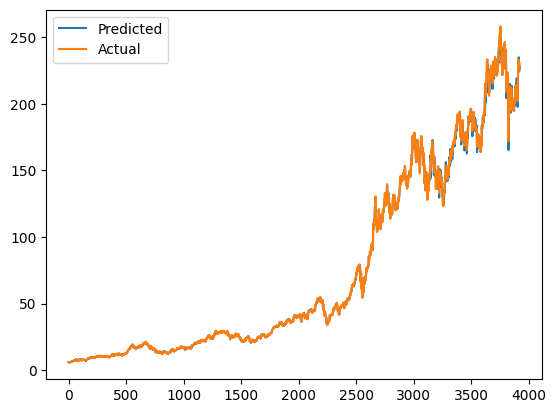

In [43]:
plot_values(df, 0.2)

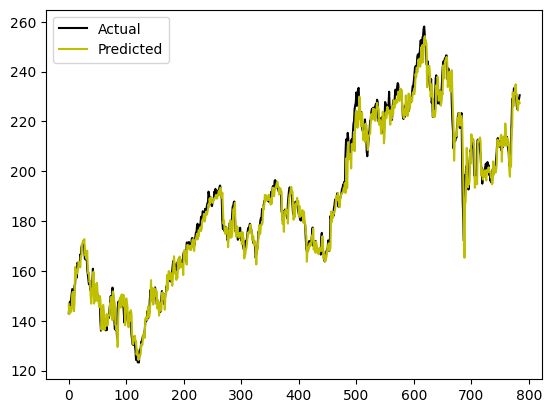

In [44]:
plt.plot(Y_test.reshape(-1), label='Actual', color='k')
plt.plot(predictions.reshape(-1), label='Predicted', color='y')
plt.legend()
plt.show()

#### Prediciendo el dia siguiente

In [45]:
last_row

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-27,228.58,230.49,30134069,1.18,2,3,8,2025,239,27,35,229.31,229.354615,228.064641,6.060884,1.821901,2.605,10.309129,NaN


In [46]:
prediction = xgb_prediction(df.values, last_row.values[0][:-1])
prediction

229.59702

In [ ]:
model.save_model('model.json')

In [ ]:
# # Create an empty model object
# loaded_model = xgb.Booster()

# # Load from the JSON file
# loaded_model.load_model('model.json')

# # Use it for predictions
# preds = loaded_model.predict(dtest)